<a href="https://colab.research.google.com/github/BelemoualemChaimae/Diagnostic-of-diabete-/blob/main/Diabetes_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the necessary libraries

In [ ]:
from __future__ import absolute_import, division, print_function  

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from subprocess import check_output
from matplotlib import pyplot
from tensorflow.keras.layers import Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score,f1_score, precision_score,recall_score
# import random undersampling and other necessary libraries 
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

%matplotlib inline

#Dataset Description

In [ ]:
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


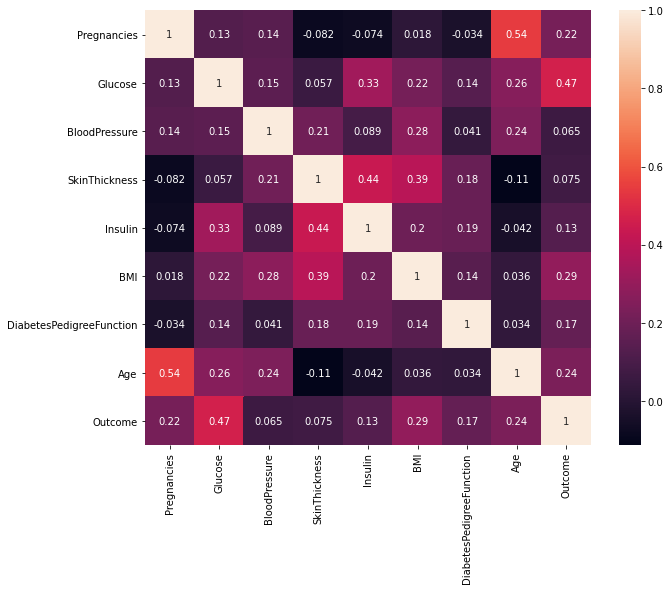

In [ ]:
import seaborn as sns
diabetes_df.corr()
f, ax = plt.subplots(1, figsize=(10,8))
sns.heatmap(diabetes_df.corr(), annot=True, ax=ax)

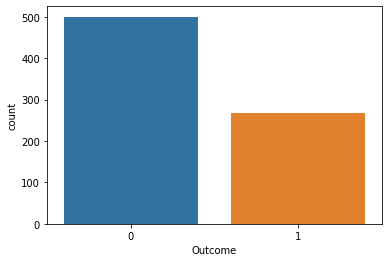

In [ ]:
sns.countplot(x=diabetes_df.Outcome)

#Data Pre-Processing

In [ ]:
def clean_data(df_raw,
               cols_with_zeros=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'],
               response = ['Outcome']):
    df = df_raw.copy()
    # replace zero with NaN in features
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
    # change response data type to int
    df[response] = df[response].astype('int')
    return df
 
diabetes_df = clean_data(diabetes_df)
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:
#Exploring the missing value
print("Proportion of missing values")
missing_values_count = diabetes_df.isna().sum()*100/diabetes_df.shape[0]
features_with_missing_values = missing_values_count[missing_values_count > 0].index.values
missing_values_count

Proportion of missing values


Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

In [ ]:
diabetes_df.dropna(subset = ["Insulin"], inplace=True)
#diabetes_df.reset_index(drop=True)

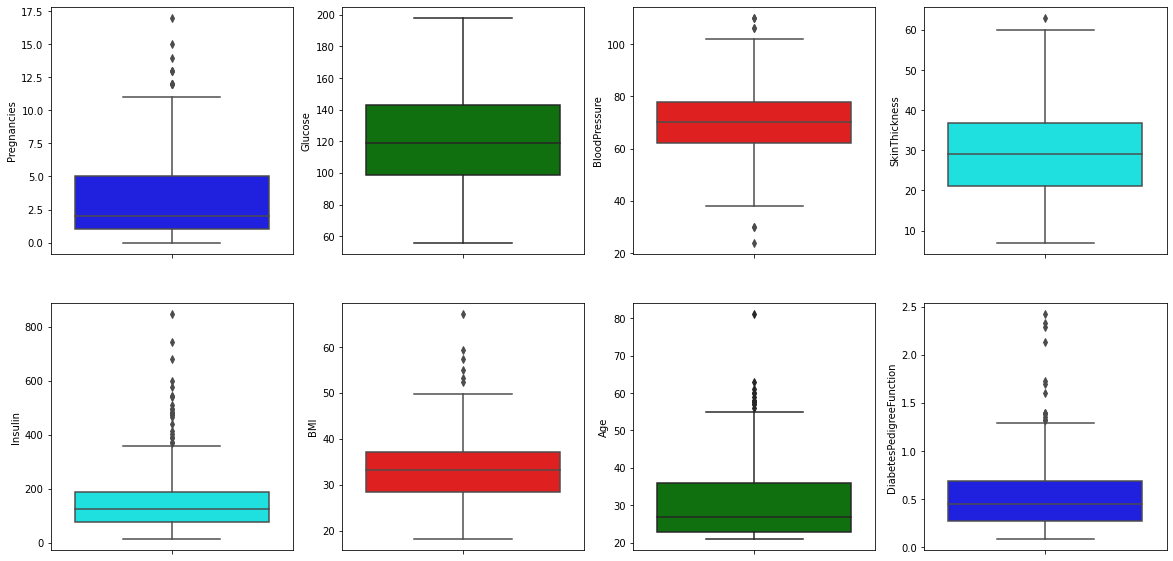

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
sns.boxplot(y = diabetes_df.Pregnancies,color='blue')
plt.subplot(2,4,2)
sns.boxplot(y = diabetes_df.Glucose,color='green')
plt.subplot(2,4,3)
sns.boxplot(y = diabetes_df.BloodPressure,color='red')
plt.subplot(2,4,4)
sns.boxplot(y = diabetes_df.SkinThickness,color='cyan')
plt.subplot(2,4,5)
sns.boxplot(y = diabetes_df.Insulin,color='cyan')
plt.subplot(2,4,6)
sns.boxplot(y = diabetes_df.BMI,color='red')
plt.subplot(2,4,7)
sns.boxplot(y = diabetes_df.Age,color='green')
plt.subplot(2,4,8)
sns.boxplot(y = diabetes_df.DiabetesPedigreeFunction,color='blue')
plt.show()

In [ ]:
# Dealing with missing values #Techniques pour traiter les valeurs manquantes
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
 
# function for KNN model-based imputation of missing values using features without NaN as predictors
def impute_model_basic(df):
  cols_nan = df.columns[df.isna().any()].tolist()
  cols_no_nan = df.columns.difference(cols_nan).values
  for col in cols_nan:
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
  return df
 
# function for KNN model-based imputation of missing values using features without NaN as predictors,
#   including progressively added imputed features
def impute_model_progressive(df):
  cols_nan = df.columns[df.isna().any()].tolist()
  cols_no_nan = df.columns.difference(cols_nan).values
  while len(cols_nan)>0:
      col = cols_nan[0]
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
      cols_nan = df.columns[df.isna().any()].tolist()
      cols_no_nan = df.columns.difference(cols_nan).values
  return df
 
# function for imputing missing data according to a given impute_strategy:
#  drop_rows: drop all rows with one or more missing values
#  drop_cols: drop columns with one or more missing values
#  model_basic: KNN-model-based imputation with fixed predictors
#  model_progressive: KNN-model-based imputation with progressively added predictors
#  mean, median, most_frequent: imputation with mean, median or most frequent values
#
#  cols_to_standardize: if provided, the specified columns are scaled between 0 and 1, after imputation
def impute_data(df_cleaned, impute_strategy=None, cols_to_standardize=None):
    df = df_cleaned.copy()
    if impute_strategy == 'drop_rows':
      df = df.dropna(axis=0)
    elif impute_strategy == 'drop_cols':
      df = df.dropna(axis=1)
    elif impute_strategy == 'model_basic':
      df = impute_model_basic(df)
    elif impute_strategy == 'model_progressive':
      df = impute_model_progressive(df)
    else:
      arr = SimpleImputer(missing_values=np.nan,strategy=impute_strategy).fit(
          df.values).transform(df.values)
      df = pd.DataFrame(data=arr, index=df.index.values, columns=df.columns.values)
    if cols_to_standardize != None:
      cols_to_standardize = list(set(cols_to_standardize) and set(df.columns.values))
      df[cols_to_standardize] = df[cols_to_standardize].astype('float')
      df[cols_to_standardize] = pd.DataFrame(data=MinMaxScaler().fit(
          df[cols_to_standardize]).transform(df[cols_to_standardize]),
                                             index=df[cols_to_standardize].index.values,
                                             columns=df[cols_to_standardize].columns.values)
    return df

In [ ]:
diabetes_df=impute_model_basic(diabetes_df)
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


In [ ]:
#removing outliers
diabetes_df=diabetes_df[diabetes_df['Insulin']<=350]
diabetes_df=diabetes_df[diabetes_df['SkinThickness']<90]
diabetes_df.shape

(369, 9)

In [ ]:
#Split the data
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["Outcome"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11111)

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
np.bincount(y_train)

array([232, 232])

In [ ]:
np.mean(y), np.mean(1-y)

(0.3116531165311653, 0.6883468834688347)

In [ ]:
# define undersampling strategy-- Balancing the data (lesss importante data is small ! )
#undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
#X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
# summarize class distribution
#print("After undersampling: ", Counter(y_train_under))

In [ ]:
#Normalisation des données 
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
X_train_norm

array([[ 6.66403137e-01, -7.46694160e-01,  1.49070628e-01, ...,
        -5.37012264e-01,  6.13680491e-01,  8.86769730e-01],
       [-8.25816295e-01, -1.29425534e+00, -3.56413650e-01, ...,
         6.47685455e-01, -4.19316561e-01, -8.39069754e-01],
       [-1.12426018e+00, -1.99132983e-01, -5.24908409e-01, ...,
         1.39957861e-01, -1.05649231e+00,  7.46099726e-02],
       ...,
       [ 1.22606910e+00,  1.27045168e+00,  2.76793324e+00, ...,
         6.59198834e-01, -1.14800801e+00,  1.03072252e+00],
       [-4.60871116e-01, -1.01907479e+00, -2.24547244e-01, ...,
        -3.08732695e-02,  1.38505377e+00, -4.55611244e-01],
       [ 4.88627931e-01, -5.85646755e-01, -7.02935290e-01, ...,
         2.06927801e-01, -1.02773526e-03, -6.55455419e-01]])

#Random Forest

In [ ]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=600,min_samples_split=3)
random_Forest_model=rf_model.fit(X_train_norm, y_train)

y_pred_class_rf_n = rf_model.predict(X_test_norm)
y_pred_prob_rf_n = rf_model.predict_proba(X_test_norm)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf_n)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf_n[:,1])))
print('precision_score is {:.3f}'.format(precision_score(y_test,y_pred_class_rf_n)))
print('f1_score is {:.3f}'.format(f1_score(y_test,y_pred_class_rf_n)))
print('recall_score is {:.3f}'.format(recall_score(y_test,y_pred_class_rf_n)))

accuracy is 0.811
roc-auc is 0.873
precision_score is 0.900
f1_score is 0.720
recall_score is 0.600


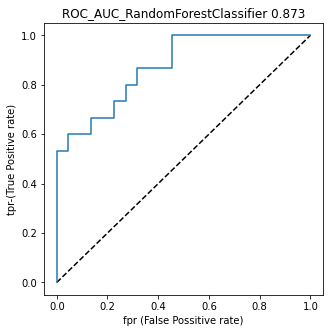

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test,y_pred_prob_rf_n[:,1])
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='RandomForestClassifier')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_RandomForestClassifier "+str(round(roc_auc_score(y_test,y_pred_prob_rf_n[:,1]),ndigits=3))
plt.title(tit)
plt.show()

In [ ]:
#Feature Selection -- need a model First
from sklearn.feature_selection import RFE
selector = RFE(rf_model, n_features_to_select=7, step=1)
selector = selector.fit(X_train_norm, y_train)
selector.support_

array([ True,  True, False,  True,  True,  True,  True,  True])

DNN

In [ ]:
#Define the Architecture of the neural network -800/500/100
def Dnn():
    inputs = Input(name='inputs', shape=[X_train.shape[1],] )
    layer = Dense(600, name='FC1',activity_regularizer=regularizers.l2(0.8))(inputs)
    layer = Activation('relu', name='Activation1')(layer)
    layer = Dropout(0.02)(layer)
    layer = Dense(300, name='FC2',activity_regularizer=regularizers.l2(0.8))(layer)
    layer = Activation('relu', name='Activation2')(layer)
    layer = Dense(100, name='FC3')(layer)
    layer = Activation('relu', name='Activation3',activity_regularizer=regularizers.l2(0.8))(layer)
    layer = Dropout(0.02)(layer)
    # layer = regularizers.l2(0.01)(layer)
    # layer = Dropout(0.01)(layer)
    layer = Dense(20, name='FC5')(layer)
    layer = Activation('relu', name='Activation4',activity_regularizer=regularizers.l2(0.8))(layer)
    layer = Dropout(0.02)(layer)
    layer = Dense(2, name='OutLayer')(layer)
    layer = Activation('softmax', name='softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model_Dnn = Dnn()
model_Dnn.summary()
#Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau()
#Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(patience=20, min_delta=0.0001)

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 8)]               0         
_________________________________________________________________
FC1 (Dense)                  (None, 600)               5400      
_________________________________________________________________
Activation1 (Activation)     (None, 600)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 600)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 300)               180300    
_________________________________________________________________
Activation2 (Activation)     (None, 300)               0         
_________________________________________________________________
FC3 (Dense)                  (None, 100)               301

In [ ]:
model_Dnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
run_hist_1 = model_Dnn.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test),epochs=500,batch_size=64, callbacks=[reduce_lr, early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 42ms/step - loss: 15.0038 - accuracy: 0.6310 - val_loss: 12.3795 - val_accuracy: 0.5946
Epoch 2/500
8/8 [==============================] - 0s 12ms/step - loss: 10.4173 - accuracy: 0.5856 - val_loss: 9.5014 - val_accuracy: 0.4865
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 7.5231 - accuracy: 0.5323 - val_loss: 7.4749 - val_accuracy: 0.3514
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 6.0313 - accuracy: 0.5234 - val_loss: 5.9195 - val_accuracy: 0.4595
Epoch 5/500
8/8 [==============================] - 0s 12ms/step - loss: 4.8894 - accuracy: 0.5572 - val_loss: 4.7262 - val_accuracy: 0.4054
Epoch 6/500
8/8 [==============================] - 0s 11ms/step - loss: 3.7031 - accuracy: 0.5322 - val_loss: 3.8116 - val_accuracy: 0.4595
Epoch 7/500
8/8 [==============================] - 0s 12ms/step - loss: 2.9085 - accuracy: 0.5627 - val_loss: 3.1076 - val_accuracy: 0.5676
Epoch 8/500
8/8 [

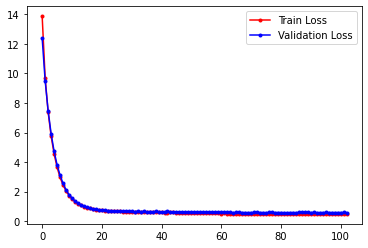

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
NB_EPOCHS = 1000  # num of epochs to test for
BATCH_SIZE = 16

def Ann():
  model = Sequential()
  # 1st layer: input_dim=8, 12 nodes, RELU
  model.add(Dense(1000, input_dim=8,kernel_initializer='uniform',activation='relu'))
  # 2nd layer: 8 nodes, RELU
  model.add(Dense(600, kernel_initializer='uniform', activation='relu'))

  model.add(Dense(400, input_dim=8,kernel_initializer='uniform',activation='relu'))
  # 2nd layer: 8 nodes, RELU
  model.add(Dense(50, kernel_initializer='uniform', activation='relu'))
  # output layer: dim=1, activation sigmoid
  model.add(Dense(2,activation='softmax',kernel_initializer='uniform'))

Ann()
# Compile the model

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# checkpoint: s*tore the best model
#ckpt_model = 'pima-weights.best.hdf5'
#checkpoint = ModelCheckpoint(ckpt_model, monitor='val_acc',verbose=1,save_best_only=True,mode='max')
#callbacks_list = [checkpoint]

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test),epochs=1000,batch_size=80, callbacks=[reduce_lr, early_stopping])


Starting training...
Epoch 1/1000
6/6 [==============================] - 2s 56ms/step - loss: 0.3887 - accuracy: 0.9400 - val_loss: 0.6610 - val_accuracy: 0.7838
Epoch 2/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.4269 - accuracy: 0.9337 - val_loss: 0.6954 - val_accuracy: 0.7297
Epoch 3/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.4169 - accuracy: 0.9373 - val_loss: 0.7209 - val_accuracy: 0.8108
Epoch 4/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.4274 - accuracy: 0.9266 - val_loss: 0.6547 - val_accuracy: 0.7568
Epoch 5/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.4232 - accuracy: 0.9237 - val_loss: 0.6545 - val_accuracy: 0.8108
Epoch 6/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.4018 - accuracy: 0.9457 - val_loss: 0.6038 - val_accuracy: 0.8108
Epoch 7/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.4134 - accuracy: 0.9357 - val_loss: 0.7152 - val_accuracy:

PCA

In [ ]:
from sklearn.decomposition import PCA
pca_diabetes = PCA(n_components=4)
principalComponents_diabetes = pca_diabetes.fit_transform(X_train_norm)

In [ ]:
principalComponents_diabetes

array([[-0.14028682, -1.37508787, -0.03217576,  0.79859738],
       [-1.26492574,  1.38853514,  1.04215516,  0.06009132],
       [-0.58109195,  0.52571631, -0.15126626, -0.99012614],
       ...,
       [ 3.42751444, -0.31736067,  1.22526843, -1.80171975],
       [-1.16806312,  0.41353864, -0.00994464,  1.42802449],
       [-0.18240807,  0.71063709,  0.48882114,  0.5633862 ]])

In [ ]:
principalComponents_diabetes_Df = pd.DataFrame(data = principalComponents_diabetes
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
principalComponents_diabetes_Df['outcome']=y_train
principalComponents_diabetes_Df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,outcome
0,-0.140287,-1.375088,-0.032176,0.798597,1
1,-1.264926,1.388535,1.042155,0.060091,0
2,-0.581092,0.525716,-0.151266,-0.990126,1
3,0.322119,0.024627,-0.613425,-1.807950,0
4,-3.203419,0.036485,0.831743,0.544309,0


In [ ]:
principalComponents_diabetes_Df['outcome']=principalComponents_diabetes_Df['outcome'].map({0: 'NDiabetes', 1: 'Diabetes'})
principalComponents_diabetes_Df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,outcome
0,-0.140287,-1.375088,-0.032176,0.798597,Diabetes
1,-1.264926,1.388535,1.042155,0.060091,NDiabetes
2,-0.581092,0.525716,-0.151266,-0.990126,Diabetes
3,0.322119,0.024627,-0.613425,-1.807950,NDiabetes
4,-3.203419,0.036485,0.831743,0.544309,NDiabetes


<Figure size 432x288 with 0 Axes>

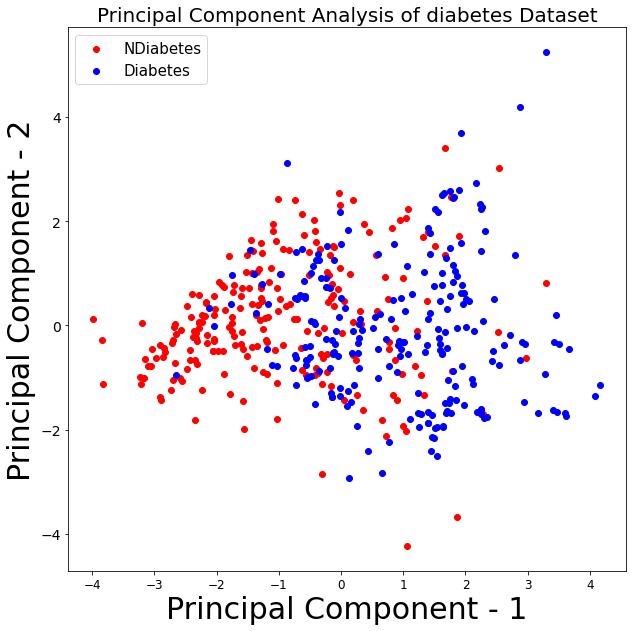

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=30)
plt.ylabel('Principal Component - 2',fontsize=30)
plt.title("Principal Component Analysis of diabetes Dataset",fontsize=20)
targets = ['NDiabetes', 'Diabetes']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalComponents_diabetes_Df['outcome'] == target
    plt.scatter(principalComponents_diabetes_Df.loc[indicesToKeep,'principal component 1'], principalComponents_diabetes_Df.loc[indicesToKeep,'principal component 2'], c = color,marker = 'o')

plt.legend(targets,prop={'size': 15})

In [ ]:
X_train_pca=principalComponents_diabetes_Df.iloc[:, :-1].values 

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_pca,y_train, test_size=0.1, random_state=11111)

Auto-encoder

Epoch 1/2000
29/29 - 1s - loss: 1.0092 - val_loss: 1.0905
Epoch 2/2000
29/29 - 0s - loss: 0.9118 - val_loss: 1.0080
Epoch 3/2000
29/29 - 0s - loss: 0.8365 - val_loss: 0.9409
Epoch 4/2000
29/29 - 0s - loss: 0.7714 - val_loss: 0.8844
Epoch 5/2000
29/29 - 0s - loss: 0.7142 - val_loss: 0.8375
Epoch 6/2000
29/29 - 0s - loss: 0.6646 - val_loss: 0.7988
Epoch 7/2000
29/29 - 0s - loss: 0.6219 - val_loss: 0.7657
Epoch 8/2000
29/29 - 0s - loss: 0.5864 - val_loss: 0.7383
Epoch 9/2000
29/29 - 0s - loss: 0.5572 - val_loss: 0.7145
Epoch 10/2000
29/29 - 0s - loss: 0.5313 - val_loss: 0.6924
Epoch 11/2000
29/29 - 0s - loss: 0.5084 - val_loss: 0.6738
Epoch 12/2000
29/29 - 0s - loss: 0.4879 - val_loss: 0.6554
Epoch 13/2000
29/29 - 0s - loss: 0.4692 - val_loss: 0.6381
Epoch 14/2000
29/29 - 0s - loss: 0.4515 - val_loss: 0.6217
Epoch 15/2000
29/29 - 0s - loss: 0.4349 - val_loss: 0.6035
Epoch 16/2000
29/29 - 0s - loss: 0.4186 - val_loss: 0.5869
Epoch 17/2000
29/29 - 0s - loss: 0.4044 - val_loss: 0.5695
Epoch 

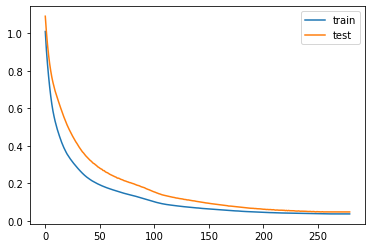

In [ ]:
#Test with Auto-encoders
# train autoencoder for DIABETES classification

n_inputs=8
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(8)(visible)
e = LeakyReLU()(e)
# encoder level 2
##e = Dense(n_inputs)(e)
#e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 7
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(8)(bottleneck)
d = LeakyReLU()(d)
# decoder level 2
#d = Dense(n_inputs*4)(d)
#d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
optimizer = Adam(learning_rate=0.0006)
model.compile(optimizer=optimizer, loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train_norm, X_train_norm, epochs=2000, validation_data=(X_test_norm,X_test_norm),batch_size=16, verbose=2,callbacks=[reduce_lr, early_stopping])
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [ ]:
# encode the train data
X_train_encode = encoder.predict(X_train_norm)
# encode the test data
X_test_encode = encoder.predict(X_test_norm)

In [ ]:
y_train.shape

(464,)

In [ ]:
#Random Forest 
rf_model = RandomForestClassifier(n_estimators=500,bootstrap = True, max_features = 'sqrt')
rf_model.fit(X_train, y_train)

y_pred_class_rf_n = rf_model.predict(X_test)
y_pred_prob_rf_n = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf_n)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf_n[:,1])))


accuracy is 0.838
roc-auc is 0.882


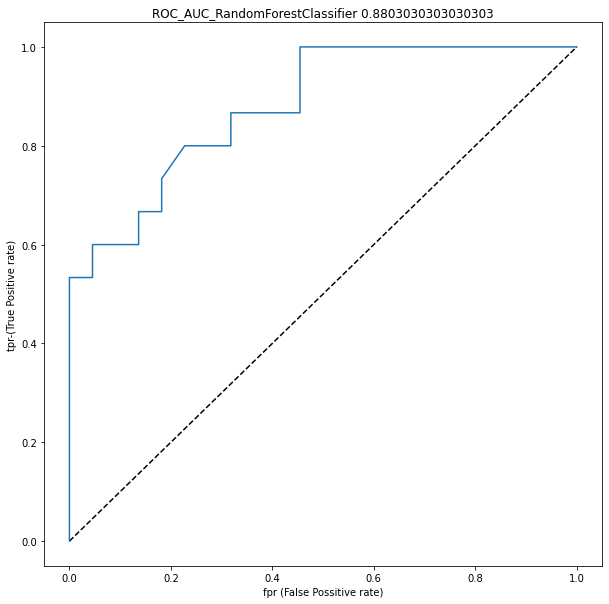

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test,y_pred_prob_rf_n[:,1])
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='RandomForestClassifier')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_RandomForestClassifier "+str(roc_auc_score(y_test,y_pred_prob_rf_n[:,1]))
plt.title(tit)
plt.show()

SVM Classifier

In [ ]:
#Training the SVM Model 
from sklearn.svm import SVC
clf = SVC(kernel = 'rbf', C = 10, gamma = 0.01 ,probability=True)
clf.fit(X_train_norm, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_class_SVM_n = clf.predict(X_test_norm)
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_SVM_n)))

accuracy is 0.838


In [ ]:
y_pred_prob_svm_n = clf.predict_proba(X_test_norm)

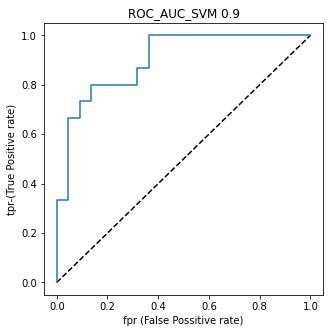

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test,y_pred_prob_svm_n[:,1])
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_SVM "+str(roc_auc_score(y_test,y_pred_prob_svm_n[:,1]))
plt.title(tit)
plt.show()

SVM Classifier with Auto-encoder

In [ ]:
#Training the SVM Model with encoded features
from sklearn.svm import SVC
clf_with_enc = SVC(kernel ='rbf', C = 1, gamma = 0.1,probability=True)
clf_with_enc.fit(X_train_encode, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_class_SVM_encoder = clf_with_enc.predict(X_test_encode)
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_SVM_encoder)))
print('f1_score is {:.3f}'.format(f1_score(y_test,y_pred_class_SVM_encoder)))

accuracy is 0.757


In [ ]:
y_pred_prob_svm_encoded_n = clf_with_enc.predict_proba(X_test_encode)

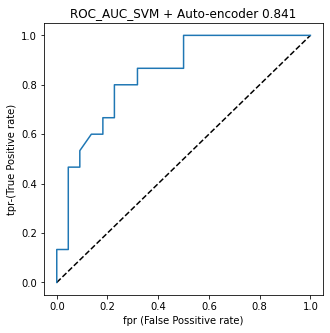

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test,y_pred_prob_svm_encoded_n[:,1])
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_SVM + Auto-encoder "+str(round(roc_auc_score(y_test,y_pred_prob_svm_encoded_n[:,1]),ndigits=3))
plt.title(tit)
plt.show()

SVM Classifier with PCA

In [ ]:
#Training the SVM Model with PCA features
from sklearn.svm import SVC
clf_with_pca = SVC(kernel = 'rbf', C = 10, gamma = 0.01,probability=True)
clf_with_pca.fit(X_train_pca, y_train_pca)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_class_SVM_pca = clf_with_pca.predict(X_test_pca)
print('accuracy is {:.3f}'.format(accuracy_score(y_test_pca,y_pred_class_SVM_pca)))

accuracy is 0.915


In [ ]:
y_pred_prob_svm_pca_n = clf_with_pca.predict_proba(X_test_pca)

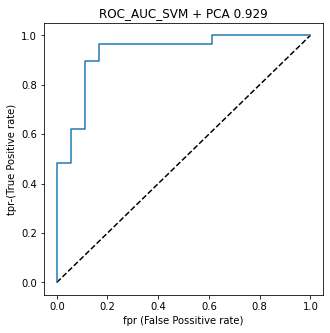

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test_pca,y_pred_prob_svm_pca_n[:,1])
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM + PCA')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_SVM + PCA "+str(round(roc_auc_score(y_test_pca,y_pred_prob_svm_pca_n[:,1]),ndigits=3))
plt.title(tit)
plt.show()

Gradient Boosting Classifier

In [ ]:
#Gradient Booting Classifier
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train_norm, y_train)
y_pred_class_gbc = GBC.predict(X_test_norm)
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_gbc)))

accuracy is 0.811


In [ ]:
y_pred_GBC_n = GBC.predict_proba(X_test_norm)

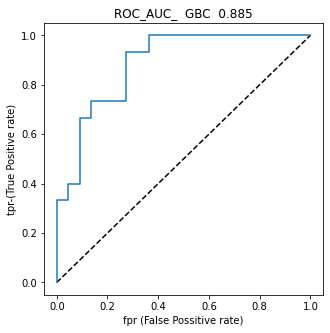

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr,thresholds=roc_curve(y_test,y_pred_GBC_n[:,1])
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel("fpr (False Possitive rate)")
plt.ylabel("tpr-(True Positive rate)")
tit="ROC_AUC_  GBC  "+str(round(roc_auc_score(y_test,y_pred_GBC_n[:,1]),ndigits=3))
plt.title(tit)
plt.show()

LSTM

In [ ]:
from keras.layers import LSTM

X_train_reshaped=X_train_norm.reshape(-1, 1, 8)
X_test_norm_reshaped=X_test_norm.reshape(-1, 1, 8)
y_train_reshaped=y_train.reshape(-1, 1, 1)
y_test_reshaped=y_test.reshape(-1, 1, 1)
def LSTM_Model():
  model = Sequential()
  model.add(LSTM(100, input_shape=(1,8),dropout=0.1, recurrent_dropout=0.1,return_sequences=False))
  #model.add(LSTM(50,dropout=0.1,input_shape=(1,8),recurrent_dropout=0.1))
  model.add(Dense(1,activation="sigmoid"))
  return model

lstm_model=LSTM_Model()
#opt=Adam(learning_rate=0.001)
lstm_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
history =lstm_model.fit(X_train_reshaped,y_train_reshaped , epochs=500, validation_data=(X_test_norm_reshaped,y_test_reshaped),batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/500
29/29 [==============================] - 2s 17ms/step - loss: 0.6744 - accuracy: 0.7400 - val_loss: 0.6646 - val_accuracy: 0.8378
Epoch 2/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.7334 - val_loss: 0.6567 - val_accuracy: 0.7838
Epoch 3/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.7452 - val_loss: 0.6493 - val_accuracy: 0.8108
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.6513 - accuracy: 0.7739 - val_loss: 0.6421 - val_accuracy: 0.8108
Epoch 5/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.7483 - val_loss: 0.6352 - val_accuracy: 0.8108
Epoch 6/500
29/29 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.8055 - val_loss: 0.6285 - val_accuracy: 0.8108
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.7667 - val_loss: 0.6219 - val_accuracy: 0.7838
Epoch 8/500


In [ ]:
from keras.layers import GRU

X_train_reshaped=X_train_norm.reshape(-1, 1, 8)
X_test_norm_reshaped=X_test_norm.reshape(-1, 1, 8)
y_train_reshaped=y_train.reshape(-1, 1, 1)
y_test_reshaped=y_test.reshape(-1, 1, 1)
def Gru_Model():
  model = Sequential()
  model.add(GRU(100, input_shape=(1,8),dropout=0.1, recurrent_dropout=0.1,return_sequences=False))
  model.add(Dense(1,activation="sigmoid"))
  return model

GRU_model=Gru_Model()
opt=Adam(learning_rate=0.005)
lstm_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
history =lstm_model.fit(X_train_reshaped,y_train_reshaped , epochs=500, validation_data=(X_test_norm_reshaped,y_test_reshaped),batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/500
29/29 [==============================] - 2s 16ms/step - loss: 0.4658 - accuracy: 0.7840 - val_loss: 0.4328 - val_accuracy: 0.8378
Epoch 2/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.7818 - val_loss: 0.4328 - val_accuracy: 0.8378
Epoch 3/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4142 - accuracy: 0.8138 - val_loss: 0.4327 - val_accuracy: 0.8378
Epoch 4/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4302 - accuracy: 0.8172 - val_loss: 0.4326 - val_accuracy: 0.8378
Epoch 5/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.7781 - val_loss: 0.4325 - val_accuracy: 0.8378
Epoch 6/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.7908 - val_loss: 0.4324 - val_accuracy: 0.8378
Epoch 7/500
29/29 [==============================] - 0s 4ms/step - loss: 0.4336 - accuracy: 0.8027 - val_loss: 0.4325 - val_accuracy: 0.8378
Epoch 8/500


LSTM with PCA

In [ ]:
principalComponents_diabetes_Df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,outcome
0,-0.140287,-1.375088,-0.032176,0.798597,Diabetes
1,-1.264926,1.388535,1.042155,0.060091,NDiabetes
2,-0.581092,0.525716,-0.151266,-0.990126,Diabetes
3,0.322119,0.024627,-0.613425,-1.807950,NDiabetes
4,-3.203419,0.036485,0.831743,0.544309,NDiabetes


In [ ]:
from keras.layers import LSTM

X_train_pca_reshaped=X_train_pca.reshape(-1, 1, 4)
X_test_pca_reshaped=X_test_pca.reshape(-1, 1, 4)
y_train_pca_reshaped=y_train_pca.reshape(-1, 1, 1)
y_test_pca_reshaped=y_test_pca.reshape(-1, 1, 1)
def LSTM_PCA_Model():
  model = Sequential()
  model.add(LSTM(100, input_shape=(1,4),dropout=0.1, recurrent_dropout=0.2,return_sequences=True))
  model.add(LSTM(50,dropout=0.1,input_shape=(1,8),recurrent_dropout=0.2))
  model.add(Dense(1,activation="sigmoid"))
  return model

lstm_PCA_model=LSTM_PCA_Model()
opt=Adam(learning_rate=0.001)
lstm_PCA_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
history =lstm_PCA_model.fit(X_train_pca_reshaped,y_train_pca_reshaped , epochs=500, validation_data=(X_test_pca_reshaped,y_test_pca_reshaped),batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/500
27/27 [==============================] - 5s 27ms/step - loss: 0.6887 - accuracy: 0.6667 - val_loss: 0.6879 - val_accuracy: 0.7234
Epoch 2/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.6707 - val_loss: 0.6882 - val_accuracy: 0.6383
Epoch 3/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.6984 - val_loss: 0.6884 - val_accuracy: 0.5957
Epoch 4/500
27/27 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.6648 - val_loss: 0.6873 - val_accuracy: 0.6383
Epoch 5/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.6624 - val_loss: 0.6875 - val_accuracy: 0.5957
Epoch 6/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6846 - accuracy: 0.6649 - val_loss: 0.6878 - val_accuracy: 0.5106
Epoch 7/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6833 - accuracy: 0.6443 - val_loss: 0.6865 - val_accuracy: 0.6170
Epoch 8/500


GRU with PCA

In [ ]:
from keras.layers import GRU

def GRU_PCA_Model():
  model = Sequential()
  model.add(GRU(120, input_shape=(1,4),dropout=0.1, recurrent_dropout=0.1,return_sequences=False))
  model.add(Dense(1,activation="sigmoid"))
  return model
gru_pca_model=GRU_PCA_Model()
opt=Adam(learning_rate=0.001)
gru_pca_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
history =gru_pca_model.fit(X_train_pca_reshaped,y_train_pca_reshaped , epochs=500, validation_data=(X_test_pca_reshaped,y_test_pca_reshaped),batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/500
27/27 [==============================] - 3s 20ms/step - loss: 0.6899 - accuracy: 0.5304 - val_loss: 0.6579 - val_accuracy: 0.8298
Epoch 2/500
27/27 [==============================] - 0s 6ms/step - loss: 0.6634 - accuracy: 0.6985 - val_loss: 0.6277 - val_accuracy: 0.8723
Epoch 3/500
27/27 [==============================] - 0s 5ms/step - loss: 0.6357 - accuracy: 0.7479 - val_loss: 0.6067 - val_accuracy: 0.8723
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.7224 - val_loss: 0.5852 - val_accuracy: 0.8723
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.7346 - val_loss: 0.5710 - val_accuracy: 0.8723
Epoch 6/500
27/27 [==============================] - 0s 5ms/step - loss: 0.5926 - accuracy: 0.7435 - val_loss: 0.5549 - val_accuracy: 0.8723
Epoch 7/500
27/27 [==============================] - 0s 5ms/step - loss: 0.5805 - accuracy: 0.7410 - val_loss: 0.5387 - val_accuracy: 0.8723
Epoch 8/500
